<a href="https://colab.research.google.com/github/MrCoeg/apiData/blob/master/Untitled18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !unzip '/content/drive/MyDrive/Skripsi_GoogleColab/data/training/rgb.zip' -d '/content/drive/MyDrive/Skripsi_GoogleColab/data/training'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Skripsi_GoogleColab/data/training/rgb/00002000.jpg  
  inflating: /content/drive/MyDrive/Skripsi_GoogleColab/data/training/rgb/00002001.jpg  
  inflating: /content/drive/MyDrive/Skripsi_GoogleColab/data/training/rgb/00002002.jpg  
  inflating: /content/drive/MyDrive/Skripsi_GoogleColab/data/training/rgb/00002003.jpg  
  inflating: /content/drive/MyDrive/Skripsi_GoogleColab/data/training/rgb/00002004.jpg  
  inflating: /content/drive/MyDrive/Skripsi_GoogleColab/data/training/rgb/00002005.jpg  
  inflating: /content/drive/MyDrive/Skripsi_GoogleColab/data/training/rgb/00002006.jpg  
  inflating: /content/drive/MyDrive/Skripsi_GoogleColab/data/training/rgb/00002007.jpg  
  inflating: /content/drive/MyDrive/Skripsi_GoogleColab/data/training/rgb/00002008.jpg  
  inflating: /content/drive/MyDrive/Skripsi_GoogleColab/data/training/rgb/00002009.jpg  
  inflating: /content/drive/MyDrive/Skripsi_GoogleColab/dat

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from tqdm import tqdm

N_KEYPOINTS = 1
N_IMG_CHANNELS = 3
RAW_IMG_SIZE = 224
MODEL_IMG_SIZE = 128
DATASET_MEANS = [0.3950, 0.4323, 0.2954]
DATASET_STDS = [0.1966, 0.1734, 0.1836]
MODEL_NEURONS = 16


COLORMAP = {
    "thumb": {"ids": [0, 1, 2, 3, 4], "color": "g"},
    "index": {"ids": [0, 5, 6, 7, 8], "color": "c"},
    "middle": {"ids": [0, 9, 10, 11, 12], "color": "b"},
    "ring": {"ids": [0, 13, 14, 15, 16], "color": "m"},
    "little": {"ids": [0, 17, 18, 19, 20], "color": "r"},
}


def projectPoints(xyz, K):
    """
    Projects 3D coordinates into image space.
    Function taken from https://github.com/lmb-freiburg/freihand
    """
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    return uv[:, :2] / uv[:, -1:]


def get_norm_params(dataloader):
    """
    Calculates image normalization parameters.
    Mean and Std are calculated for each channel separately.

    Borrowed from this StackOverflow discussion:
    https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
    """
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    for i, sample in tqdm(enumerate(dataloader)):
        data = sample["image_raw"]
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return {"mean": mean, "std": std}


def vector_to_heatmaps(keypoints):
    """
    Creates 2D heatmaps from keypoint locations for a single image
    Input: array of size N_KEYPOINTS x 2
    Output: array of size N_KEYPOINTS x MODEL_IMG_SIZE x MODEL_IMG_SIZE
    """
    heatmaps = np.zeros([N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE])
    for k, (x, y) in enumerate(keypoints):
        x, y = int(x * MODEL_IMG_SIZE), int(y * MODEL_IMG_SIZE)
        if (0 <= x < MODEL_IMG_SIZE) and (0 <= y < MODEL_IMG_SIZE) and k < N_KEYPOINTS:
            heatmaps[k, int(y), int(x)] = 1

    heatmaps = blur_heatmaps(heatmaps)
    return heatmaps


def blur_heatmaps(heatmaps):
    """Blurs heatmaps using GaussinaBlur of defined size"""
    heatmaps_blurred = heatmaps.copy()
    for k in range(len(heatmaps)):
        if heatmaps_blurred[k].max() == 1:
            heatmaps_blurred[k] = cv2.GaussianBlur(heatmaps[k], (51, 51), 3)
            heatmaps_blurred[k] = heatmaps_blurred[k] / heatmaps_blurred[k].max()
    return heatmaps_blurred


class IoULoss(nn.Module):
    """
    Intersection over Union Loss.
    IoU = Area of Overlap / Area of Union
    IoU loss is modified to use for heatmaps.
    """

    def __init__(self):
        super(IoULoss, self).__init__()
        self.EPSILON = 1e-6

    def _op_sum(self, x):
        return x.sum(-1).sum(-1)

    def forward(self, y_pred, y_true):
        inter = self._op_sum(y_true * y_pred)
        union = (
            self._op_sum(y_true ** 2)
            + self._op_sum(y_pred ** 2)
            - self._op_sum(y_true * y_pred)
        )
        iou = (inter + self.EPSILON) / (union + self.EPSILON)
        iou = torch.mean(iou)
        return 1 - iou


def heatmaps_to_coordinates(heatmaps):
    """
    Heatmaps is a numpy array
    Its size - (batch_size, n_keypoints, img_size, img_size)
    """
    batch_size = heatmaps.shape[0]
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])
    normalized = heatmaps / sums
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)

    arr = np.tile(np.float32(np.arange(0, 128)), [batch_size, 21, 1])
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)
    keypoints = np.stack([x, y], axis=-1)
    return keypoints / 128


def show_data(dataset, n_samples=12):
    """
    Function to visualize data
    Input: torch.utils.data.Dataset
    """
    n_cols = 4
    n_rows = int(np.ceil(n_samples / n_cols))
    plt.figure(figsize=[15, n_rows * 4])

    ids = np.random.choice(dataset.__len__(), n_samples, replace=False)
    print(ids)
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        image = sample["image_raw"].numpy()
        image = np.moveaxis(image, 0, -1)
        keypoints = sample["keypoints"].numpy()
        keypoints = keypoints * RAW_IMG_SIZE

        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
    plt.tight_layout()
    plt.show()


def show_batch_predictions(batch_data, model):
    """
    Visualizes image, image with actual keypoints and
    image with predicted keypoints.
    Finger colors are in COLORMAP.

    Inputs:
    - batch data is batch from dataloader
    - model is trained model
    """
    inputs = batch_data["image"]
    true_keypoints = batch_data["keypoints"].numpy()
    batch_size = true_keypoints.shape[0]
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.detach().numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)
    images = batch_data["image_raw"].numpy()
    images = np.moveaxis(images, 1, -1)

    plt.figure(figsize=[12, 4 * batch_size])
    for i in range(batch_size):
        # image = sample["image_raw"].numpy()
        # image = np.moveaxis(image, 0, -1)
        # keypoints = sample["keypoints"].numpy()
        # keypoints = keypoints * RAW_IMG_SIZE

        # plt.subplot(n_rows, n_cols, i)
        # plt.imshow(image)
        # plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        # for finger, params in COLORMAP.items():
        #     plt.plot(
        #         keypoints[params["ids"], 0],
        #         keypoints[params["ids"], 1],
        #         params["color"],
        #     )
        image = images[i]
        true_keypoints_img = true_keypoints[i] * RAW_IMG_SIZE
        pred_keypoints_img = pred_keypoints[i] * RAW_IMG_SIZE

        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(image)
        plt.scatter(true_keypoints_img[:, 0], true_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                true_keypoints_img[params["ids"], 0],
                true_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("True Keypoints")
        plt.axis("off")

        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(image)
        plt.scatter(pred_keypoints_img[:, 0], pred_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                pred_keypoints_img[params["ids"], 0],
                pred_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("Pred Keypoints")
        plt.axis("off")
    plt.tight_layout()
    plt.tight_layout()
    plt.show()

In [15]:
import numpy as np
import os
from PIL import Image
import json
import torch
from torchvision import transforms
from torch.utils.data import Dataset


class FreiHAND(Dataset):
    """
    Class to load FreiHAND dataset. Only training part is used here.
    Augmented images are not used, only raw - first 32,560 images

    Link to dataset:
    https://lmb.informatik.uni-freiburg.de/resources/datasets/FreihandDataset.en.html
    """

    def __init__(self, config, set_type="train"):
        self.device = config["device"]
        self.image_dir = os.path.join(config["data_dir"], "training/rgb")
        self.image_names = np.sort(os.listdir(self.image_dir))

        self.image_names = [img for img in self.image_names if not img.endswith(('.ipynb_checkpoint', '.zip'))]

        fn_K_matrix = os.path.join(config["data_dir"], "training_K.json")
        with open(fn_K_matrix, "r") as f:
            self.K_matrix = np.array(json.load(f))

        fn_anno = os.path.join(config["data_dir"], "training_xyz.json")
        with open(fn_anno, "r") as f:
            self.anno = np.array(json.load(f))

        if set_type == "train":
            n_start = 0
            n_end = 5000
        elif set_type == "val":
            n_start = 5000
            n_end = 7000
        else:
            n_start = 6000
            n_end = 7000
            
        #n_start = 0
        #n_end = 4

        self.image_names = self.image_names[n_start:n_end]
        self.K_matrix = self.K_matrix[n_start:n_end]
        self.anno = self.anno[n_start:n_end]
        print(self.image_names)

        self.image_raw_transform = transforms.ToTensor()
        self.image_transform = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

    def __len__(self):
        return len(self.anno)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_raw = Image.open(os.path.join(self.image_dir, image_name))
        image = self.image_transform(image_raw)
        image_raw = self.image_raw_transform(image_raw)
        keypoints = projectPoints(self.anno[idx], self.K_matrix[idx])
        keypoints = keypoints / RAW_IMG_SIZE
        heatmaps = vector_to_heatmaps(keypoints)
        keypoints = torch.from_numpy(keypoints)
        heatmaps = torch.from_numpy(np.float32(heatmaps))

        return {
            "image": image,
            "keypoints": keypoints,
            "heatmaps": heatmaps,
            "image_name": image_name,
            "image_raw": image_raw,
        }


In [5]:
import torch
import torch.nn as nn

# from utils.prep_utils import MODEL_NEURONS


class ConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(out_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class ShallowUNet(nn.Module):
    """
    Implementation of UNet, slightly modified:
    - less downsampling blocks
    - less neurons in the layers
    - Batch Normalization added
    
    Link to paper on original UNet:
    https://arxiv.org/abs/1505.04597
    """
    
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.conv_down1 = ConvBlock(in_channel, MODEL_NEURONS)
        self.conv_down2 = ConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.conv_down3 = ConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.conv_bottleneck = ConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        self.maxpool = nn.MaxPool2d(2)
        self.upsamle = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        self.conv_up1 = ConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up2 = ConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up3 = ConvBlock(MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS)

        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        conv_d1 = self.conv_down1(x)
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        conv_b = self.conv_bottleneck(self.maxpool(conv_d3))

        conv_u1 = self.conv_up1(torch.cat([self.upsamle(conv_b), conv_d3], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsamle(conv_u1), conv_d2], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsamle(conv_u2), conv_d1], dim=1))

        out = self.conv_out(conv_u3)
        return out

In [6]:
import numpy as np
import torch


class Trainer:
    def __init__(self, model, criterion, optimizer, config, scheduler=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss = {"train": [], "val": []}
        self.epochs = config["epochs"]
        self.batches_per_epoch = config["batches_per_epoch"]
        self.batches_per_epoch_val = config["batches_per_epoch_val"]
        self.device = config["device"]
        self.scheduler = scheduler
        self.checkpoint_frequency = 100
        self.early_stopping_epochs = 10
        self.early_stopping_avg = 10
        self.early_stopping_precision = 5

    def train(self, train_dataloader, val_dataloader):
        for epoch in range(self.epochs):
            self._epoch_train(train_dataloader)
            self._epoch_eval(val_dataloader)
            print(
                "Epoch: {}/{}, Train Loss={}, Val Loss={}".format(
                    epoch + 1,
                    self.epochs,
                    np.round(self.loss["train"][-1], 10),
                    np.round(self.loss["val"][-1], 10),
                )
            )

            # reducing LR if no improvement
            if self.scheduler is not None:
                self.scheduler.step(self.loss["train"][-1])

            # saving model
            if (epoch + 1) % self.checkpoint_frequency == 0:
                torch.save(
                    self.model.state_dict(), "model_{}".format(str(epoch + 1).zfill(3))
                )

            # early stopping
            if epoch < self.early_stopping_avg:
                min_val_loss = np.round(np.mean(self.loss["val"]), self.early_stopping_precision)
                no_decrease_epochs = 0

            else:
                val_loss = np.round(
                    np.mean(self.loss["val"][-self.early_stopping_avg:]), 
                                    self.early_stopping_precision
                )
                if val_loss >= min_val_loss:
                    no_decrease_epochs += 1
                else:
                    min_val_loss = val_loss
                    no_decrease_epochs = 0
                    #print('New min: ', min_val_loss)

            if no_decrease_epochs > self.early_stopping_epochs:
                print("Early Stopping")
                break

        torch.save(self.model.state_dict(), "model_final")
        return self.model

    def _epoch_train(self, dataloader):
        self.model.train()
        running_loss = []

        for i, data in enumerate(dataloader, 0):
            inputs = data["image"].to(self.device)
            labels = data["heatmaps"].to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())
            if i == self.batches_per_epoch:
                epoch_loss = np.mean(running_loss)
                self.loss["train"].append(epoch_loss)
                break

    def _epoch_eval(self, dataloader):
        self.model.eval()
        running_loss = []

        with torch.no_grad():
            for i, data in enumerate(dataloader, 0):
                inputs = data["image"].to(self.device)
                labels = data["heatmaps"].to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss.append(loss.item())
                if i == self.batches_per_epoch_val:
                    epoch_loss = np.mean(running_loss)
                    self.loss["val"].append(epoch_loss)
                    break


In [7]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

import sys
sys.path.append("../")

# from utils.dataset import FreiHAND
# from utils.model import ShallowUNet
# from utils.trainer import Trainer
# from utils.prep_utils import (
#     blur_heatmaps,
#     IoULoss,
#     COLORMAP,
#     N_KEYPOINTS,
#     N_IMG_CHANNELS,
#     get_norm_params,
#     show_data,
# )

In [8]:
config = {
    "data_dir": "/content/drive/My Drive/Skripsi_GoogleColab/data",
    "epochs": 1000,
    "batch_size": 48,
    "batches_per_epoch": 50,
    "batches_per_epoch_val": 20,
    "learning_rate": 0.1,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [9]:
train_dataset = FreiHAND(config=config, set_type="train")
train_dataloader = DataLoader(
    train_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

['00000000.jpg', '00000001.jpg', '00000002.jpg', '00000003.jpg', '00000004.jpg', '00000005.jpg', '00000006.jpg', '00000007.jpg', '00000008.jpg', '00000009.jpg', '00000010.jpg', '00000011.jpg', '00000012.jpg', '00000013.jpg', '00000014.jpg', '00000015.jpg', '00000016.jpg', '00000017.jpg', '00000018.jpg', '00000019.jpg', '00000020.jpg', '00000021.jpg', '00000022.jpg', '00000023.jpg', '00000024.jpg', '00000025.jpg', '00000026.jpg', '00000027.jpg', '00000028.jpg', '00000029.jpg', '00000030.jpg', '00000031.jpg', '00000032.jpg', '00000033.jpg', '00000034.jpg', '00000035.jpg', '00000036.jpg', '00000037.jpg', '00000038.jpg', '00000039.jpg', '00000040.jpg', '00000041.jpg', '00000042.jpg', '00000043.jpg', '00000044.jpg', '00000045.jpg', '00000046.jpg', '00000047.jpg', '00000048.jpg', '00000049.jpg', '00000050.jpg', '00000051.jpg', '00000052.jpg', '00000053.jpg', '00000054.jpg', '00000055.jpg', '00000056.jpg', '00000057.jpg', '00000058.jpg', '00000059.jpg', '00000060.jpg', '00000061.jpg', '000000

In [10]:
val_dataset = FreiHAND(config=config, set_type="val")
val_dataloader = DataLoader(
    val_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

['00005000.jpg', '00005001.jpg', '00005002.jpg', '00005003.jpg', '00005004.jpg', '00005005.jpg', '00005006.jpg', '00005007.jpg', '00005008.jpg', '00005009.jpg', '00005010.jpg', '00005011.jpg', '00005012.jpg', '00005013.jpg', '00005014.jpg', '00005015.jpg', '00005016.jpg', '00005017.jpg', '00005018.jpg', '00005019.jpg', '00005020.jpg', '00005021.jpg', '00005022.jpg', '00005023.jpg', '00005024.jpg', '00005025.jpg', '00005026.jpg', '00005027.jpg', '00005028.jpg', '00005029.jpg', '00005030.jpg', '00005031.jpg', '00005032.jpg', '00005033.jpg', '00005034.jpg', '00005035.jpg', '00005036.jpg', '00005037.jpg', '00005038.jpg', '00005039.jpg', '00005040.jpg', '00005041.jpg', '00005042.jpg', '00005043.jpg', '00005044.jpg', '00005045.jpg', '00005046.jpg', '00005047.jpg', '00005048.jpg', '00005049.jpg', '00005050.jpg', '00005051.jpg', '00005052.jpg', '00005053.jpg', '00005054.jpg', '00005055.jpg', '00005056.jpg', '00005057.jpg', '00005058.jpg', '00005059.jpg', '00005060.jpg', '00005061.jpg', '000050

[3147 4253 4231  512 1615 3063  291  622]


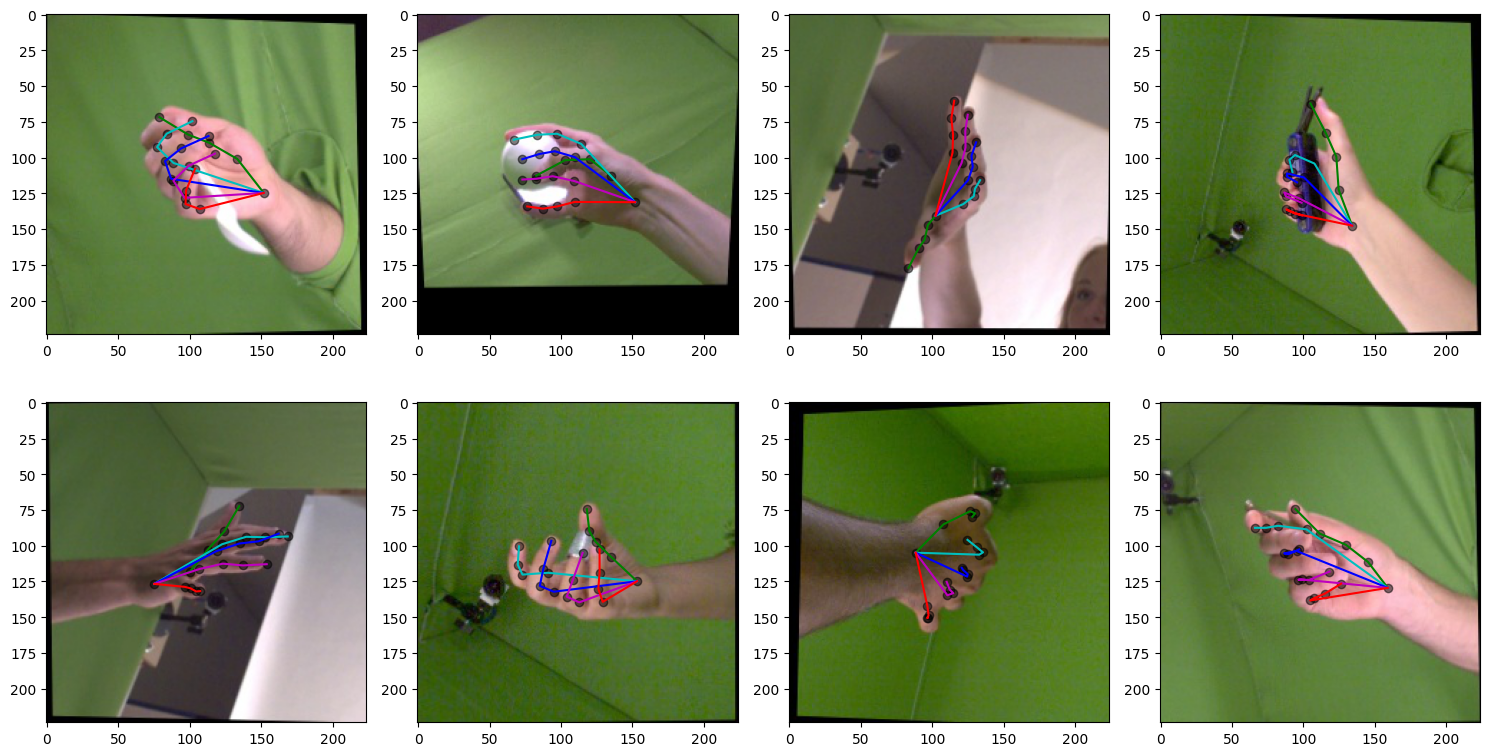

In [ ]:
show_data(train_dataset, n_samples=8)

[1010 1398 1193  465 1912  794  486  384]


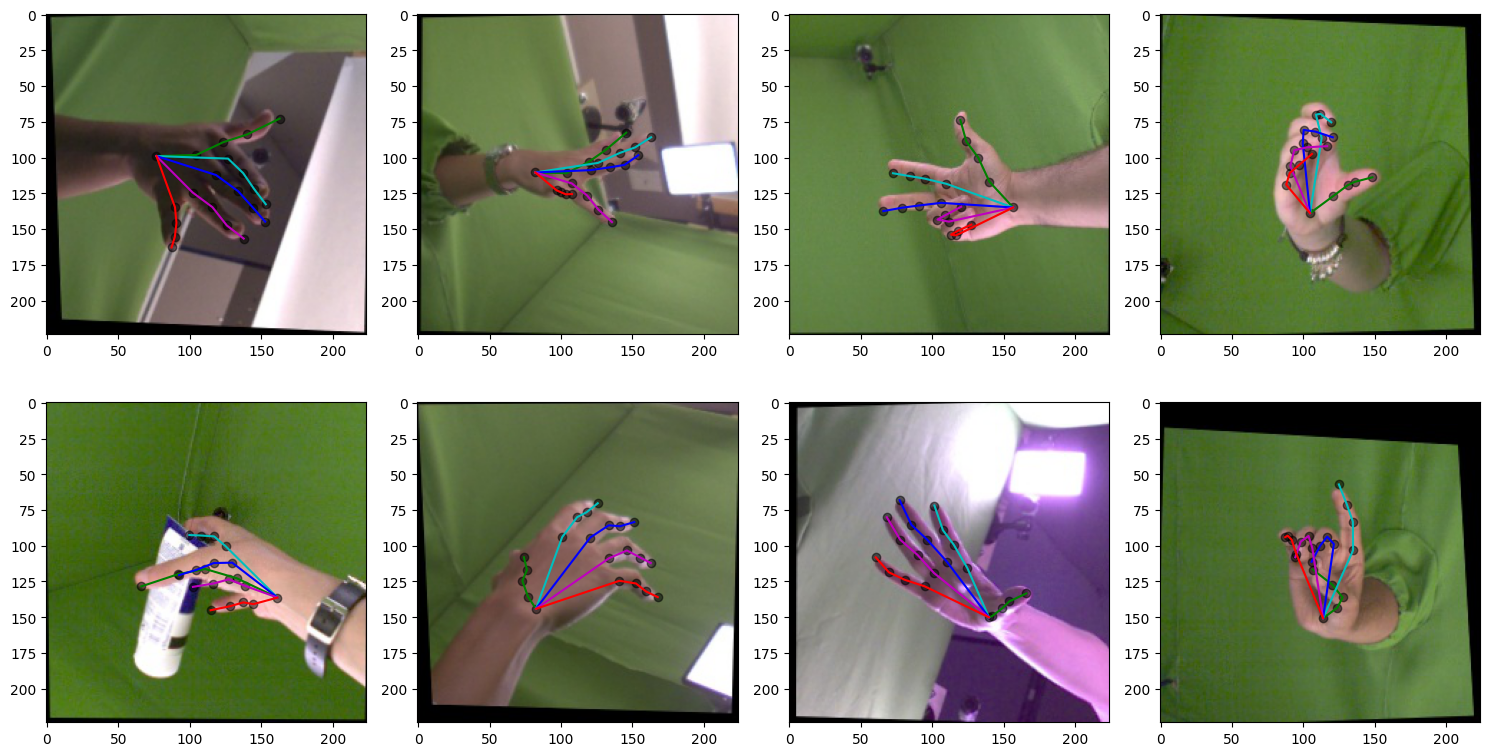

In [ ]:
show_data(val_dataset, n_samples=8)

In [11]:
model = ShallowUNet(N_IMG_CHANNELS, N_KEYPOINTS)
model = model.to(config["device"])

criterion = IoULoss()
optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=20, verbose=True, threshold=0.00001
)

In [12]:
trainer = Trainer(model, criterion, optimizer, config, scheduler)
model = trainer.train(train_dataloader, val_dataloader)

Epoch: 1/1000, Train Loss=0.9912297924, Val Loss=0.9895470228
Epoch: 2/1000, Train Loss=0.9816284928, Val Loss=0.9642881524
Epoch: 3/1000, Train Loss=0.8886888612, Val Loss=0.8812256001
Epoch: 4/1000, Train Loss=0.7827020556, Val Loss=0.8006083909
Epoch: 5/1000, Train Loss=0.7043014963, Val Loss=0.69863379
Epoch: 6/1000, Train Loss=0.6262298682, Val Loss=0.6274653985
Epoch: 7/1000, Train Loss=0.5840304821, Val Loss=0.6001232153
Epoch: 8/1000, Train Loss=0.5464186762, Val Loss=0.5820820161
Epoch: 9/1000, Train Loss=0.5129295307, Val Loss=0.5508440222
Epoch: 10/1000, Train Loss=0.4886135401, Val Loss=0.5218773371
Epoch: 11/1000, Train Loss=0.4693366581, Val Loss=0.508625408
Epoch: 12/1000, Train Loss=0.457943803, Val Loss=0.4851406273
Epoch: 13/1000, Train Loss=0.4358446002, Val Loss=0.4813236651
Epoch: 14/1000, Train Loss=0.4199220585, Val Loss=0.4837556538
Epoch: 15/1000, Train Loss=0.4040308525, Val Loss=0.4639814922
Epoch: 16/1000, Train Loss=0.3963912597, Val Loss=0.4737155608
Epoch

In [13]:
torch.save(model.state_dict(), )

TypeError: ignored

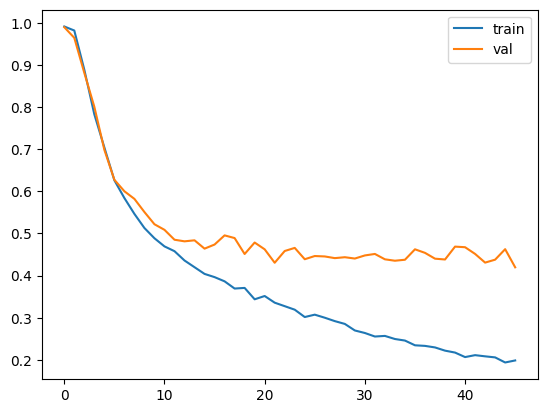

/content/drive/My Drive/Skripsi_GoogleColab/data/training/rgb/.ipynb_checkpoints


In [14]:
plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()
print('/content/drive/My Drive/Skripsi_GoogleColab/data/training/rgb/.ipynb_checkpoints')

In [39]:
config = {
    "data_dir": "/content/drive/My Drive/Skripsi_GoogleColab/data",
    "model_path": "model_final",
    "test_batch_size": 4,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [40]:
test_dataset = FreiHAND(config=config, set_type="test")
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

['00006000.jpg', '00006001.jpg', '00006002.jpg', '00006003.jpg', '00006004.jpg', '00006005.jpg', '00006006.jpg', '00006007.jpg', '00006008.jpg', '00006009.jpg', '00006010.jpg', '00006011.jpg', '00006012.jpg', '00006013.jpg', '00006014.jpg', '00006015.jpg', '00006016.jpg', '00006017.jpg', '00006018.jpg', '00006019.jpg', '00006020.jpg', '00006021.jpg', '00006022.jpg', '00006023.jpg', '00006024.jpg', '00006025.jpg', '00006026.jpg', '00006027.jpg', '00006028.jpg', '00006029.jpg', '00006030.jpg', '00006031.jpg', '00006032.jpg', '00006033.jpg', '00006034.jpg', '00006035.jpg', '00006036.jpg', '00006037.jpg', '00006038.jpg', '00006039.jpg', '00006040.jpg', '00006041.jpg', '00006042.jpg', '00006043.jpg', '00006044.jpg', '00006045.jpg', '00006046.jpg', '00006047.jpg', '00006048.jpg', '00006049.jpg', '00006050.jpg', '00006051.jpg', '00006052.jpg', '00006053.jpg', '00006054.jpg', '00006055.jpg', '00006056.jpg', '00006057.jpg', '00006058.jpg', '00006059.jpg', '00006060.jpg', '00006061.jpg', '000060

In [42]:
model = ShallowUNet(3, 1)
model.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device(config["device"]))
)
model.eval()
print("Model loaded")

Model loaded


In [43]:
accuracy_all = []

for data in tqdm(test_dataloader):
    inputs = data["image"]
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    accuracy_image = accuracy_keypoint.mean(axis=1)
    accuracy_all.extend(list(accuracy_image))

100%|██████████| 250/250 [00:49<00:00,  5.08it/s]


In [44]:
error = np.mean(accuracy_all)
print("Average error per keypoint: {:.1f}% from image size".format(error * 100))

for img_size in [MODEL_IMG_SIZE, RAW_IMG_SIZE]:
    error_pixels = error * img_size
    image_size = f"{img_size}x{img_size}"
    print(
        "Average error per keypoint: {:.0f} pixels for image {}".format(
            error_pixels, image_size
        )
    )

Average error per keypoint: 23.3% from image size
Average error per keypoint: 30 pixels for image 128x128
Average error per keypoint: 52 pixels for image 224x224


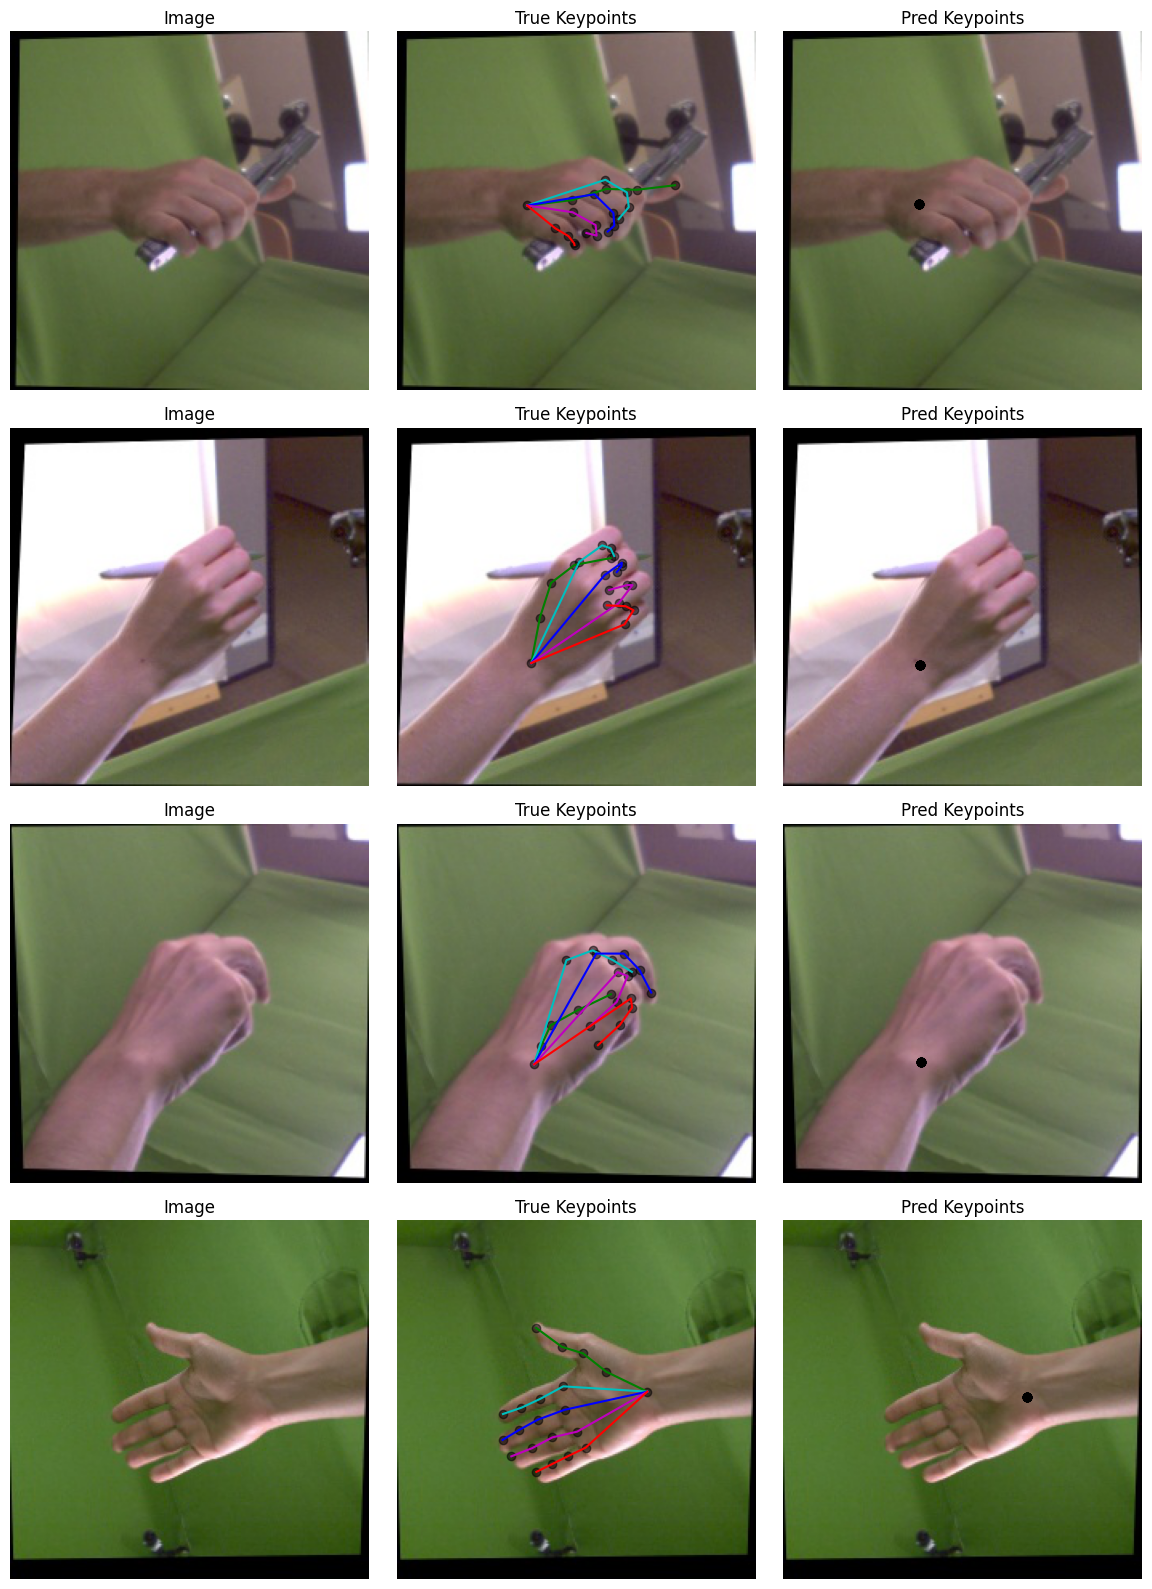

In [50]:
for data in test_dataloader:
    show_batch_predictions(data, model)
    break